In [3]:
import argparse
import numpy as np
import sys, os
import torch
import time
import h5py
import torch.nn

#import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from utils import torch_utils,  default_paths
from utils import nsd_utils
from model_fitting import initialize_fitting

device = 'cpu:0'
# device = initialize_fitting.init_cuda()


In [4]:
subject=1;
use_node_storage=False;
debug=True;


In [3]:
# Load and prepare the image set to work with (all images for the current subject, 10,000 ims)
stim_root = default_paths.stim_root
image_data = nsd_utils.get_image_data(subject)  
image_data = nsd_utils.image_uncolorize_fn(image_data)

#     # Need to have size a multiple of 8, for the pyramid to work right
#     process_at_size=240
#     resample_fn = torch.nn.Upsample((process_at_size, process_at_size), mode="bilinear", align_corners=True)

# Params for the spatial aspect of the model (possible pRFs)
aperture = 1.0
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [4]:
# Set up the pyramid
feature_types_exclude = []
n_prf_sd_out = 2
do_varpart=False # this doesn't do anything here
group_all_hl_feats = False # this doesn't do anything here

compute_features = True
_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
_feature_extractor = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn,sample_batch_size=batch_size, \
                                                                         feature_types_exclude=feature_types_exclude, \
                                               n_prf_sd_out=n_prf_sd_out, aperture=aperture, do_varpart = do_varpart, \
                              compute_features=compute_features, group_all_hl_feats = group_all_hl_feats, device=device)

n_features = _feature_extractor.n_features_total
n_images = image_data.shape[0]
n_prfs = models.shape[0]
n_batches = int(np.ceil(n_images/batch_size))

features_each_prf = np.zeros((n_images, n_features, n_prfs), dtype=np.float32)

Feature types to exclude from the model:
[]


In [7]:
image_order = nsd_utils.get_master_image_order()
# Choosing which sessions we're analyzing now - same sessions as the voxel data that will be loaded.
session_inds = nsd_utils.get_session_inds_full()
sessions = np.arange(0,10)
if np.isscalar(sessions):
    sessions = [sessions]
sessions = np.array(sessions)
inds2use = np.isin(session_inds, sessions)
image_order = image_order[inds2use]
shared_1000_inds = image_order<1000

image_order_val = image_order[shared_1000_inds]
image_order_trn = image_order[~shared_1000_inds]


In [8]:
# bb=0

# batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

# print('Extracting features for images [%d - %d]'%(batch_inds[0], batch_inds[-1]))

batch_inds = image_order_val[[532, 533, 534]]

image_batch = torch_utils._to_torch(image_data[batch_inds,:,:,:], device)

#         image_batch = resample_fn(image_batch)

_feature_extractor.clear_big_features()

Clearing steerable pyramid features from memory.


In [9]:
vind = 943; mind = 353; tind = 533
x,y,sigma = (0.2026315789473685, 0.4342105263157895, 0.03999999910593033)
vind, mind, x, y, sigma, tind

(943, 353, 0.2026315789473685, 0.4342105263157895, 0.03999999910593033, 533)

In [10]:
mm = mind;
x,y,sigma = models[mm,:]
print('Getting features for pRF [x,y,sigma]:')
print([x,y,sigma])

features_batch, _ = _feature_extractor(image_batch, models[mm],mm)


Getting features for pRF [x,y,sigma]:
[0.2026315789473685, 0.4342105263157895, 0.03999999910593033]
Running steerable pyramid feature extraction...
Images array shape is:
torch.Size([3, 1, 240, 240])
time elapsed = 0.77713
Computing higher order correlations...
time elapsed = 0.51596
Final size of features concatenated is [3 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']

WARNING THERE ARE ZEROS IN FEATURES MATRIX

zeros for columns:
(array([4]),)
Final size of features concatenated is [3 x 641]
Final size of features concatenated is [3 x 641]


In [14]:
torch.any(torch.abs(features_batch)>10**6)

tensor(False)

In [97]:
images = image_batch;
prf_params = models[mm];
mm = mind

if _feature_extractor.fmaps is None:
    _feature_extractor.get_maps(images)
else:
    assert(images.shape[0]==_feature_extractor.fmaps[0][0].shape[0])

if isinstance(prf_params, torch.Tensor):
    prf_params = torch_utils.get_value(prf_params)
assert(np.size(prf_params)==3)
prf_params = np.squeeze(prf_params)
if isinstance(images, torch.Tensor):
    images = torch_utils.get_value(images)

print('Computing higher order correlations...')

t = time.time()
pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
    magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
    magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
    real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =  \
            get_higher_order_features(_feature_extractor.fmaps, images, prf_params, sample_batch_size=_feature_extractor.sample_batch_size, n_prf_sd_out=_feature_extractor.n_prf_sd_out, aperture=_feature_extractor.aperture, device=_feature_extractor.device)



Computing higher order correlations...


In [53]:
pixel_stats[1,:]

tensor([ 1.0000e+00,  1.9413e-22, -4.6218e+10,  2.2720e+21,  0.0000e+00,
         1.0000e+00], device='cuda:0')

In [98]:
fmaps = _feature_extractor.fmaps;
sample_batch_size=_feature_extractor.sample_batch_size;
n_prf_sd_out=_feature_extractor.n_prf_sd_out;
aperture=_feature_extractor.aperture;
device=_feature_extractor.device
keep_orig_shape=False

fmaps_complex_all, fmaps_resid_all, fmaps_lowpass_recon_all, fmaps_coarser_upsampled_all = fmaps

n_trials = fmaps_complex_all[0].shape[0]
x,y,sigma = prf_params

n_sf = len(fmaps_complex_all)
n_ori = fmaps_complex_all[0].shape[1]

# all pairs of different orientation channels.
ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
n_ori_pairs = np.shape(ori_pairs)[0]

# mean, variance, skew, kurtosis, min, max
pixel_stats = torch.zeros((n_trials,6), device=device)


In [99]:
batch_inds = [1]
n_pix = 240   
g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
spatial_weights = g[2][0]
wmean, wvar, wskew, wkurt = texture_utils.get_weighted_pixel_features(images[batch_inds], \
                                                                      spatial_weights, device=device)

In [100]:
[wmean, wvar, wskew, wkurt]

[tensor([[1.]]),
 tensor([[1.9413e-22]]),
 tensor([[-4.6218e+10]]),
 tensor([[2.2720e+21]])]

In [101]:
image_batch = images[batch_inds]
if isinstance(image_batch, np.ndarray):
    image_batch = torch_utils._to_torch(image_batch, device).contiguous()
if isinstance(spatial_weights, np.ndarray):
    spatial_weights = torch_utils._to_torch(spatial_weights, device)

assert(image_batch.shape[2]==spatial_weights.shape[0] and image_batch.shape[3]==spatial_weights.shape[1])
assert(image_batch.shape[1]==1)

batch_size = image_batch.shape[0]
n_channels = image_batch.shape[1]
n_pix = image_batch.shape[2]

image_batch = image_batch.view([batch_size, n_channels, n_pix**2])
spatial_weights = spatial_weights/torch.sum(spatial_weights)
spatial_weights = spatial_weights.view([1,1,n_pix**2]).expand([batch_size,n_channels,-1]) # [batch_size x n_channels x nPix x nPix]    

ims_weighted = image_batch * spatial_weights

In [128]:
wmean = torch.sum(ims_weighted, axis=2).view([batch_size,-1,1])

wvar = torch.sum(spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2, axis=2).view([batch_size,-1,1])
# wvar += 10**(-6)

wskew = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**3 / (wvar**(3/2)), axis=2).view([batch_size,-1,1])
# wskew += 10**(-6)

wkurt = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**4 / (wvar**(2)), axis=2).view([batch_size,-1,1])
# wkurt += 10**(-6)


In [107]:
_feature_extractor.device

'cpu:0'

In [131]:
wskew

tensor([[[-4.6218e+10]]])

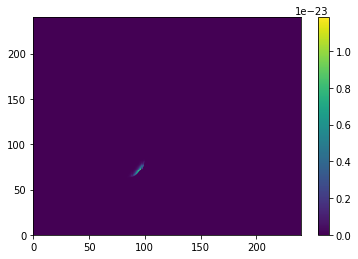

In [108]:
submean_multweights = spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2
plt.figure;
plt.pcolormesh(np.reshape(submean_multweights.detach().cpu().numpy(), [240,240]));
plt.colorbar()

In [110]:
wvar = np.mean(submean_multweights.detach().cpu().numpy())
wvar

3.370376e-27

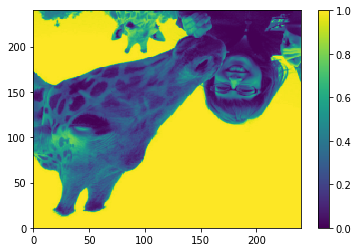

In [87]:
plt.figure();
plt.pcolormesh((images[batch_inds][0,0,:,:]))
plt.colorbar()

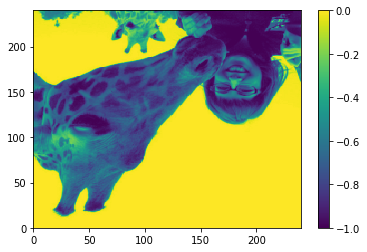

In [83]:
submean = (image_batch - wmean.expand([-1,-1,n_pix**2]))
plt.figure;
plt.pcolormesh(np.reshape(submean.detach().cpu().numpy(), [240,240]));
plt.colorbar()

In [70]:
ims_weighted.shape

torch.Size([1, 1, 57600])

In [74]:
image_batch

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0454, 0.0331, 0.0359]]],
       device='cuda:0')

In [73]:
torch.sum(ims_weighted)

tensor(1., device='cuda:0')

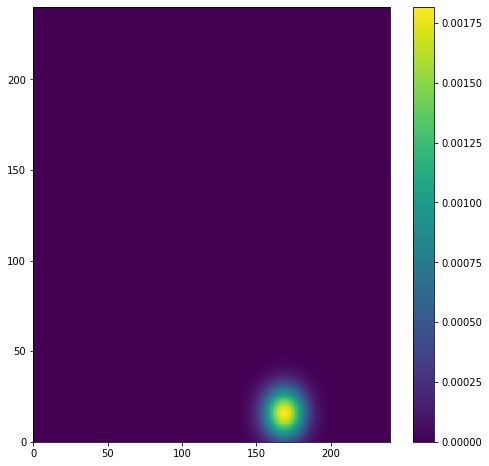

In [76]:
plt.figure(figsize=(8,8));
# plt.pcolormesh((images[batch_inds][0,0,:,:]))
plt.pcolormesh(np.reshape(ims_weighted[0,0,:].detach().cpu().numpy(), [240,240]))
plt.colorbar()

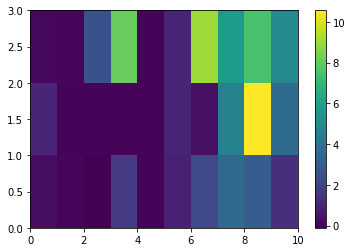

In [11]:
import matplotlib.pyplot as plt
plt.figure;
features_batch_np = features_batch.detach().cpu().numpy()
plt.pcolormesh(features_batch_np[:,0:10])
# plt.pcolormesh(scipy.stats.zscore(feat_np[:,0:10], axis=0))
plt.colorbar()

In [11]:
features_file = '/user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py'

t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,mind])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

computed_feats = values

Took 90.30389 seconds to load file


In [24]:
# computed_feats_use = computed_feats[inds2use,:]
val_feats = computed_feats[image_order_val]

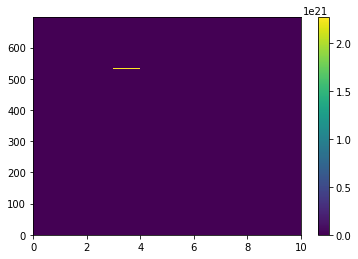

In [113]:
# feat_np = feat.detach().cpu().numpy()
import matplotlib.pyplot as plt
plt.figure;
plt.pcolormesh(val_feats[:,0:10])
# plt.pcolormesh(scipy.stats.zscore(feat_np[:,0:10], axis=0))
plt.colorbar()

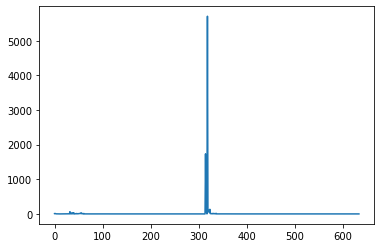

In [115]:
plt.figure();
plt.plot(np.max(val_feats[:,7:], axis=0))

In [40]:
val_feats[batch_inds,0:10]

array([[ 2.58592606e-01,  2.17249896e-02, -1.12263530e-01,
         1.73147297e+00,  0.00000000e+00,  8.62702012e-01,
         2.28610277e+00,  3.45988083e+00,  3.01251483e+00,
         1.33347595e+00],
       [ 1.00000000e+00,  1.94133633e-22, -4.62181745e+10,
         2.27199198e+21,  0.00000000e+00,  1.00000000e+00,
         3.27354878e-01,  4.60902262e+00,  1.05596581e+01,
         3.55912805e+00],
       [ 1.27084106e-01,  4.64429855e-02,  2.53636074e+00,
         8.07001591e+00,  0.00000000e+00,  9.70593750e-01,
         9.04548073e+00,  5.72385168e+00,  7.47031879e+00,
         4.96029186e+00]])

In [39]:
features_batch_np[:,0:10]

array([[ 8.8548946e-01,  6.1925617e-05, -1.7871112e-01,  2.9368379e+00,
         0.0000000e+00,  9.9215686e-01,  2.2828919e-01,  1.6519949e+00,
         5.2806892e+00,  1.8109199e+00],
       [ 3.6074293e-01,  1.2454685e-02,  2.2812612e+00,  9.5367718e+00,
         9.7205497e-02,  1.0000000e+00,  1.3640897e+00,  4.8749323e+00,
         8.9703121e+00,  3.5484776e+00],
       [ 5.6229424e-01,  1.0705587e-02, -4.1494098e-01,  2.1143873e+00,
         3.6384317e-03,  9.8008865e-01,  2.7523012e+00,  3.1669099e+00,
         7.2131128e+00,  2.8315091e+00]], dtype=float32)

In [46]:
import numpy as np
import torch
import time
import os
import h5py
import gc
from collections import OrderedDict
import torch.nn as nn
import pyrtools as pt
from utils import numpy_utils, torch_utils, texture_utils, prf_utils, default_paths
pyramid_texture_feat_path = default_paths.pyramid_texture_feat_path
from sklearn import decomposition
class texture_feature_extractor(nn.Module):
    
    """
    Module to compute higher-order texture statistics of input images (e.g. Portilla & Simoncelli 2000, IJCV)
    Statistics are computed within a specified region of space (a voxel's pRF)
    Can specify different subsets of features to include (i.e. pixel-level stats, simple/complex cells, cross-correlations, auto-correlations)
    Inputs to the forward pass are images and pRF parameters of interest [x,y,sigma]
    """
    
    def __init__(self,_fmaps_fn, subject=None, sample_batch_size=100, feature_types_exclude=None, n_prf_sd_out=2, \
                 aperture=1.0, do_varpart=False, group_all_hl_feats=False, compute_features=True, \
                do_pca_hl = False, min_pct_var = 99, max_pc_to_retain = 100, device=None):
        
        print('TEST version')
        super(texture_feature_extractor, self).__init__()
        
        self.fmaps_fn = _fmaps_fn   
        self.n_sf = _fmaps_fn.pyr_height
        self.n_ori =  _fmaps_fn.n_ori
       
        self.sample_batch_size = sample_batch_size       
        self.n_prf_sd_out = n_prf_sd_out
        self.aperture = aperture
        self.device = device       
        
        self.do_varpart = do_varpart
        self.group_all_hl_feats = group_all_hl_feats
   
        self.update_feature_list(feature_types_exclude)
        self.do_pca_hl = do_pca_hl
        if self.do_pca_hl:
            # this only makes sense to do if these other params are set this way...
            assert(self.group_all_hl_feats==True)
            self.min_pct_var = min_pct_var
            self.n_ll_feats = np.sum(np.array(self.feature_type_dims_include)[self.feature_is_ll])
            self.n_hl_feats = np.sum(np.array(self.feature_type_dims_include)[~self.feature_is_ll])
            self.max_pc_to_retain = np.min([self.n_hl_feats, max_pc_to_retain])
            # trimming off the last few columns
            self.feature_column_labels = self.feature_column_labels[0:self.max_pc_to_retain + self.n_ll_feats]
             
        else:
            self.min_pct_var = None
            self.max_pc_to_retain = None  
        
        # if compute features is false, this means the features are already generated, so will be looking for a 
        # saved h5py file of pre-computed features. If true, will run the extraction step now.
        self.compute_features = compute_features
        self.subject = subject
        
        if not self.compute_features:
            self.features_file = os.path.join(pyramid_texture_feat_path, 'S%d_features_each_prf_%dori_%dsf.h5py'%(self.subject, self.n_ori, self.n_sf))
            if not os.path.exists(self.features_file):
                raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)                
            self.prf_batch_size=50
            self.features_each_prf_batch = None
            self.prf_inds_loaded = []
        else:
            self.fmaps = None
    
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations.
        """
       
        print('Initializing for fitting')
        
        if self.do_pca_hl:

            print('Initializing arrays for PCA params')
            n_prfs = len(models)
            
            n_hl_feat_each_prf = self.n_hl_feats * np.ones(shape=(n_prfs,),dtype=int)      
            self.n_hl_feat_each_prf = n_hl_feat_each_prf

            # will need to save pca parameters to reproduce it during validation stage
            # max pc to retain is just to save space, otherwise the "pca_wts" variable becomes huge 
            # NOTE here these parameters are just for the HL/higher level features.
            
            self.pca_wts = [np.zeros(shape=(self.max_pc_to_retain, n_hl_feat_each_prf[mm]), dtype=dtype) for mm in range(n_prfs)] 
            self.pca_pre_z_mean = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_z_std = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_mean = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pct_var_expl = np.zeros(shape=(self.max_pc_to_retain, n_prfs), dtype=dtype)
            self.n_comp_needed = np.full(shape=(n_prfs), fill_value=-1, dtype=int)
            
            self.max_features = self.max_pc_to_retain + self.n_ll_feats
                
        else:
            self.max_features = self.n_features_total    
            
        self.clear_big_features()
        
        if not self.compute_features:
            # Prepare for loading the pre-computed features: as a compromise between speed and ram usage, will load them in
            # batches of multiple prfs at a time. 
            n_prfs = models.shape[0]
            n_prf_batches = int(np.ceil(n_prfs/self.prf_batch_size))          
            self.prf_batch_inds = [np.arange(self.prf_batch_size*bb, np.min([self.prf_batch_size*(bb+1), n_prfs])) for bb in range(n_prf_batches)]
        
    def update_feature_list(self, feature_types_exclude):
        
        # First defining all the possible features and their dimensionality (fixed)
        feature_types_all = ['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', \
            'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', \
            'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', \
            'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
        self.feature_types_all = feature_types_all
        feature_type_dims = [6,16,16,10,1,\
                        272,73,25,\
                        24,24,48,96,\
                       10,20]
        self.feature_is_ll = list(np.ones((5,))==1) + list(np.zeros((9,))==1)
        self.feature_type_dims_all = feature_type_dims        
         
        # Decide which features to ignore, or use all features      
        if feature_types_exclude is None:
            feature_types_exclude = []
        # a few shorthands for ignoring sets of features at a time
        if 'crosscorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'crosscorrs' in ff])
        if 'autocorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'autocorrs' in ff])
        if 'pixel' in feature_types_exclude:
            feature_types_exclude.extend(['pixel_stats'])
        self.feature_types_exclude = feature_types_exclude
        print('Feature types to exclude from the model:')
        print(self.feature_types_exclude)    

        # Now list all the features that we do want to use
        self.feature_types_include  = [ff for ff in feature_types_all if not ff in self.feature_types_exclude]
        if len(self.feature_types_include)==0:
            raise ValueError('you have specified too many features to exclude, and now you have no features left! aborting.')
            
        self.feature_type_dims_include = [feature_type_dims[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in self.feature_types_exclude]
        # how many features will be needed, in total?
        self.n_features_total = np.sum(self.feature_type_dims_include)
        self.feature_is_ll = np.array([self.feature_is_ll[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in self.feature_types_exclude])

        # Numbers that define which feature types are in which columns of final output matrix
        self.feature_column_labels = np.squeeze(np.concatenate([fi*np.ones([1,self.feature_type_dims_include[fi]]) for fi in range(len(self.feature_type_dims_include))], axis=1).astype('int'))
        assert(np.size(self.feature_column_labels)==self.n_features_total)
        
        if self.group_all_hl_feats:
            # In this case pretend there are just two groups of features:
            # Lower-level which includes pixel, gabor-like, and marginal stats of lowpass/highpass recons.
            # Higher-level which includes all autocorrelations and cross-correlations. 
            # This makes it simpler to do variance partition analysis.
            # if do_varpart=False, this does nothing.
            self.feature_column_labels[self.feature_is_ll[self.feature_column_labels]] = 0
            self.feature_column_labels[~self.feature_is_ll[self.feature_column_labels]] = 1
            self.feature_group_names = ['lower-level', 'higher-level']
            
            print('Grouping lower level features:')
            print(np.array(self.feature_types_include)[self.feature_is_ll])
            print('Grouping higher level features:')
            print(np.array(self.feature_types_include)[~self.feature_is_ll])
        else:
            self.feature_group_names = self.feature_types_include
            
    def get_partial_versions(self):
        
        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
            
        n_feature_types = len(self.feature_group_names)
        partial_version_names = ['full_model'] 
        masks = np.ones([1,self.max_features])
        
        if self.do_varpart and n_feature_types>1:
            
            # "Partial versions" will be listed as: [full model, model w only first set of features, model w only second set, ...             
            partial_version_names += ['just_%s'%ff for ff in self.feature_group_names]
            masks2 = np.concatenate([np.expand_dims(np.array(self.feature_column_labels==ff).astype('int'), axis=0) for ff in np.arange(0,n_feature_types)], axis=0)
            masks = np.concatenate((masks, masks2), axis=0)
            
            if n_feature_types > 2:
                # if more than two types, also include models where we leave out first set of features, leave out second set of features...]
                partial_version_names += ['leave_out_%s'%ff for ff in self.feature_group_names]           
                masks3 = np.concatenate([np.expand_dims(np.array(self.feature_column_labels!=ff).astype('int'), axis=0) for ff in np.arange(0,n_feature_types)], axis=0)
                masks = np.concatenate((masks, masks3), axis=0)           
        
        # masks always goes [n partial versions x n total features]
        return masks, partial_version_names

    
    def get_maps(self, images):
    
        print('Running steerable pyramid feature extraction...')
        print('Images array shape is:')
        print(images.shape)
        t = time.time()
        if isinstance(images, torch.Tensor):
            images = torch_utils.get_value(images)
        fmaps = self.fmaps_fn(images, to_torch=False, device=self.device)        
        self.fmaps = fmaps
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

    def load_precomputed_features(self, image_inds, prf_model_index):
    
        if prf_model_index not in self.prf_inds_loaded:
            
            
            batch_to_use = np.where([prf_model_index in self.prf_batch_inds[bb] for \
                                     bb in range(len(self.prf_batch_inds))])[0][0]
            assert(prf_model_index in self.prf_batch_inds[batch_to_use])

            print('Loading pre-computed features for models [%d - %d] from %s'%(self.prf_batch_inds[batch_to_use][0], \
                                                                              self.prf_batch_inds[batch_to_use][-1], self.features_file))
            self.features_each_prf_batch = None
            gc.collect()
            torch.cuda.empty_cache()
       
            t = time.time()
            with h5py.File(self.features_file, 'r') as data_set:
                values = np.copy(data_set['/features'][:,:,self.prf_batch_inds[batch_to_use]])
                data_set.close() 
            elapsed = time.time() - t
            print('Took %.5f seconds to load file'%elapsed)

            self.prf_inds_loaded = self.prf_batch_inds[batch_to_use]
            self.features_each_prf_batch = values[image_inds,:,:]
            values=None
            
        else:
            assert(len(image_inds)==self.features_each_prf_batch.shape[0])
            
        index_into_batch = np.where(prf_model_index==self.prf_inds_loaded)[0][0]
        print('Index into batch for prf %d: %d'%(prf_model_index, index_into_batch))
        features_in_prf = self.features_each_prf_batch[:,:,index_into_batch]
        values=None
        print('Size of features array for this image set and prf is:')
        print(features_in_prf.shape)
        
        return features_in_prf
        
    
    def clear_big_features(self):
        
        if self.compute_features:
            print('Clearing steerable pyramid features from memory.')
            self.fmaps = None
        else:
            print('Clearing precomputed features from memory.')
            self.features_each_prf_batch = None
            self.prf_inds_loaded = []
            gc.collect()
            torch.cuda.empty_cache()
        
        
    def forward(self, images, prf_params, prf_model_index, fitting_mode=True):
        
        if not self.compute_features:
            
            # Load from file the features for this set of images
            # In this case, the item passed in through "images" must actually be the indices of the images to use, not images themselves.
            # Check to make sure this is the case.
            assert(len(images.shape)==1)
            image_inds = images
            features = self.load_precomputed_features(image_inds, prf_model_index)            
            assert(features.shape[0]==len(image_inds))
            features = torch_utils._to_torch(features, self.device)
            
            # Choosing which of these columns to include in model (might be all)
            feature_column_labels_all = np.squeeze(np.concatenate([fi*np.ones([1,self.feature_type_dims_all[fi]]) for fi in range(len(self.feature_type_dims_all))], axis=1).astype('int'))
            all_feat = OrderedDict()
            for fi, ff in enumerate(self.feature_types_all):
                if ff in self.feature_types_include:
                    all_feat[ff] = features[:,feature_column_labels_all==fi]
                else:
                    all_feat[ff] = None
            
        else:
            
            if self.fmaps is None:
                self.get_maps(images)
            else:
                assert(images.shape[0]==self.fmaps[0][0].shape[0])

            if isinstance(prf_params, torch.Tensor):
                prf_params = torch_utils.get_value(prf_params)
            assert(np.size(prf_params)==3)
            prf_params = np.squeeze(prf_params)
            if isinstance(images, torch.Tensor):
                images = torch_utils.get_value(images)

            print('Computing higher order correlations...')

            t = time.time()
            pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
                magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
                magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
                real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =  \
                        get_higher_order_features(self.fmaps, images, prf_params, sample_batch_size=self.sample_batch_size, n_prf_sd_out=self.n_prf_sd_out, aperture=self.aperture, device=self.device)


            elapsed =  time.time() - t
            print('time elapsed = %.5f'%elapsed)

            all_feat = OrderedDict({'pixel_stats':pixel_stats, 'mean_magnitudes':mean_magnitudes, 'mean_realparts':mean_realparts, \
                                    'marginal_stats_lowpass_recons':marginal_stats_lowpass_recons, 'variance_highpass_resid':variance_highpass_resid, \
                'magnitude_feature_autocorrs':magnitude_feature_autocorrs, 'lowpass_recon_autocorrs':lowpass_recon_autocorrs, 'highpass_resid_autocorrs':highpass_resid_autocorrs, \
                'magnitude_within_scale_crosscorrs':magnitude_within_scale_crosscorrs, 'real_within_scale_crosscorrs':real_within_scale_crosscorrs, \
                'magnitude_across_scale_crosscorrs':magnitude_across_scale_crosscorrs, 'real_imag_across_scale_crosscorrs':real_imag_across_scale_crosscorrs, \
                'real_spatshift_within_scale_crosscorrs':real_spatshift_within_scale_crosscorrs, 'real_spatshift_across_scale_crosscorrs':real_spatshift_across_scale_crosscorrs})

        # Now concatenating everything to a big matrix
        feature_names_full = list(all_feat.keys())
        feature_names = [fname for fname in feature_names_full if fname in self.feature_types_include]
        assert(feature_names==self.feature_types_include) # double check here that the order is correct

        for ff, feature_name in enumerate(feature_names):   
            assert(all_feat[feature_name] is not None)
            if ff==0:
                all_feat_concat = all_feat[feature_name]
            else:               
                all_feat_concat = torch.cat((all_feat_concat, all_feat[feature_name]), axis=1)

        assert(all_feat_concat.shape[1]==self.n_features_total)
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        print('Feature types included are:')
        print(feature_names)
        
        if torch.any(torch.isnan(all_feat_concat)):
            print('\nWARNING THERE ARE NANS IN FEATURES MATRIX\n')
        if torch.any(torch.all(all_feat_concat==0, axis=0)):
            print('\nWARNING THERE ARE ZEROS IN FEATURES MATRIX\n')
            print('zeros for columns:')
            print(np.where(torch_utils.get_value(torch.all(all_feat_concat==0, axis=0))))

        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        
        if self.do_pca_hl:    
            features_ll = all_feat_concat[:,0:self.n_ll_feats]
            features_hl = all_feat_concat[:,self.n_ll_feats:]
            print('Running PCA on higher-level features...')
            features_hl = self.reduce_pca(features_hl, prf_model_index, fitting_mode)
            
            all_feat_concat = torch.cat((features_ll, features_hl), axis=1)
            
            feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
            feature_inds_defined[0:all_feat_concat.shape[1]] = 1
        else:
            feature_inds_defined = np.ones((self.n_features_total,), dtype=bool)
        
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        
        return all_feat_concat, feature_inds_defined
    
    
    def reduce_pca(self, features, prf_model_index, fitting_mode=True):
        
        if torch.is_tensor(features):
            features = features.detach().cpu().numpy()
            was_tensor=True
        else:
            was_tensor=False
            
        n_trials = features.shape[0]
        n_features_actual = features.shape[1]
        
        assert(n_features_actual == self.n_hl_feat_each_prf[prf_model_index])
        print('Preparing for PCA: original dims of features:')
        print(features.shape)
        
        if fitting_mode:
            
            # Going to perform pca on the raw features
            # First make sure it hasn't been done yet!
            assert(self.n_comp_needed[prf_model_index]==-1) 
            print('Running PCA...')
            pca = decomposition.PCA(n_components = np.min([np.min([self.max_pc_to_retain, n_features_actual]), n_trials]), copy=False)
            # normalize the columns first
            features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
            features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
            features -= features_m
            features /= features_s 
            self.pca_pre_z_mean[prf_model_index][0:n_features_actual] = features_m
            self.pca_pre_z_std[prf_model_index][0:n_features_actual] = features_s
            
            # Perform PCA to decorrelate feats and reduce dimensionality
            scores = pca.fit_transform(features)           
            features = None            
            wts = pca.components_
            ev = pca.explained_variance_
            ev = ev/np.sum(ev)*100
            # wts/components goes [ncomponents x nfeatures]. 
            # nfeatures is always actual number of raw features
            # ncomponents is min(ntrials, nfeatures)
            # to save space, only going to save up to some max number of components.
            n_components_actual = np.min([wts.shape[0], self.max_pc_to_retain])
            # save a record of the transformation to be used for validating model
            self.pca_wts[prf_model_index][0:n_components_actual,0:n_features_actual] = wts[0:n_components_actual,:] 
            # mean of each feature, nfeatures long - needed to reproduce transformation
            self.pca_pre_mean[prf_model_index][0:n_features_actual] = pca.mean_ 
            # max len of ev is the number of components
            self.pct_var_expl[0:n_components_actual,prf_model_index] = ev[0:n_components_actual]  
            n_components_reduced = int(np.where(np.cumsum(ev)>self.min_pct_var)[0][0] if np.any(np.cumsum(ev)>self.min_pct_var) else len(ev))
            n_components_reduced = np.max([n_components_reduced, 1])
            self.n_comp_needed[prf_model_index] = n_components_reduced
            print('Retaining %d components to expl %d pct var'%(n_components_reduced, self.min_pct_var))
            
            assert(n_components_reduced<=self.max_pc_to_retain)            
            features_reduced = scores[:,0:n_components_reduced]
            
        else:
            
            # This is a validation pass, going to use the pca pars that were computed on training set
            # Make sure it has been done already!
            assert(self.n_comp_needed[prf_model_index]!=-1)
            print('Applying pre-computed PCA matrix...')
            # Apply the PCA transformation, just as it was done during training
            features -= np.tile(np.expand_dims(self.pca_pre_z_mean[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            features /= np.tile(np.expand_dims(self.pca_pre_z_std[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            
            features_submean = features - np.tile(np.expand_dims(self.pca_pre_mean[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            features_reduced = features_submean @ np.transpose(self.pca_wts[prf_model_index][0:self.n_comp_needed[prf_model_index],0:n_features_actual])               
                       
        features = None
        
        if was_tensor:
            features_reduced = torch.tensor(features_reduced).to(self.device)
        
        return features_reduced
    
    
    
    
    
class steerable_pyramid_extractor(nn.Module):
    
    """
    Module that utilizes steerable pyramid ( https://pyrtools.readthedocs.io/en/latest/) to extract features.
    For a batch of input images, will return all the pyramid coefficients, as well as additional types of feature maps
    (i.e. partially reconstructed lowpass images at several frequency levels, upsampled feature maps).
    These are used by 'get_higher_order_features' to extract various textural features of the image.
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height # how many spatial frequencies?
        self.pyr = None
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(image_batch[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)
            self.pyr = pyr # storing the most recently generated pyramid, in case we need its properties later
            
            if ii==0:  
                
                # Initialize all the feature maps we want to store...
                fmaps_complex = []
                fmaps_coarser_upsampled = []
               
                # Will generate several low-pass filtered representations of the image - will use these as additional feature maps for 
                # computing autocorrelations and marginal statistics.
                fmaps_lowpass_recon = []
                fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
               
                # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
                sf_reverse  = self.pyr_height  # need to go backward because pyr comes out in the opposite order from what i want
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))
                    
                    # Initialize "parent" representations for this level (map from the next coarsest resolution, upsampled to the finer scale)
                    # To be used for cross-scale comparisons.
                    if sf==0:
                        # this will be the lowpass residual (non-oriented).
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, 1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))                     
                    else:
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))     
                        
                    fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                         pyr.pyr_coeffs[sf_reverse,0].shape[1])))

                fmaps_resid = []    
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))

            # First get lowpass filtered representation of the image
            lowpass_recon = pyr.recon_pyr(levels='residual_lowpass', bands='all', twidth=1) 
            scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size['residual_lowpass'][0]
            lowpass_recon = texture_utils.shrink(lowpass_recon, scale_by)*scale_by**2
            fmaps_lowpass_recon[0][ii,0,:,:] = lowpass_recon
            
            # Get the "parent" for lowest SF level (upsample the residual lowpass)
#             print(pyr.pyr_coeffs['residual_lowpass'].shape)
            upsampled = texture_utils.expand(pyr.pyr_coeffs['residual_lowpass'], factor=2)/2**2
#             print(upsampled.shape)
            fmaps_coarser_upsampled[0][ii,0,:,:] = upsampled
            
            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height # need to go backward because pyr comes out in the opposite order from what i want
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     

                    # These are the main feature maps of the pyramid - one feature map per scale per orientation band.
                    # Complex number, can take the magnitude or real/imaginary part to simulate complex or simple cell-type responses.
                    fmaps_complex[sf][ii,oo,:,:] = pyr.pyr_coeffs[(sf_reverse,oo)]
                    
                    if sf<self.pyr_height-1:
                        # Store this as a "parent" representation, will be used for the next most fine SF level (i.e. sf+1)
                        upsampled = texture_utils.expand(pyr.pyr_coeffs[(sf_reverse,oo)], factor=2)/2**2
                        # Double the phase (angle of the complex number); note this doesn't affect the magnitude. 
                        phase_doubled = texture_utils.double_phase(upsampled)
                        fmaps_coarser_upsampled[sf+1][ii,oo,:,:] = phase_doubled
                   
                        
                # Get the bandpass filtered representation for this scale
                bandpass_image = np.real(pyr.recon_pyr(levels=sf_reverse, bands='all', twidth=1))
                scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size[(sf_reverse,0)][0]
                bandpass_image = texture_utils.shrink(bandpass_image, factor=scale_by)*scale_by**2
                
                # Add it onto the lowpass_recon (gets modified every loop iteration)
                lowpass_recon = texture_utils.expand(lowpass_recon, factor=2)/2**2
                lowpass_recon = lowpass_recon + bandpass_image
                fmaps_lowpass_recon[sf+1][ii,0,:,:] = lowpass_recon
            

            # Grab residual feature maps, the lowest and highest levels of the pyramid
            fmaps_resid[0][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_resid[1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
            
            
        elapsed = time.time() - t
#         print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_complex = [torch.from_numpy(fm).to(device) for fm in fmaps_complex]            
            fmaps_resid = [torch_utils._to_torch(fm, device=device) for fm in fmaps_resid]
            fmaps_lowpass_recon = [torch_utils._to_torch(fm, device=device) for fm in fmaps_lowpass_recon]                      
            fmaps_coarser_upsampled = [torch.from_numpy(fm).to(device) for fm in fmaps_coarser_upsampled]

        return fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled
    
   


def get_higher_order_features(fmaps, images, prf_params, sample_batch_size=20, n_prf_sd_out=2, aperture=1.0, device=None, keep_orig_shape=False):

    """
    Compute higher order texture features for a batch of images.
    Input the module that defines steerable pyramid (i.e. 'steerable_pyramid_extractor'), and desired prf parameters.
    Returns arrays of each higher order feature.  
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """

    fmaps_complex_all, fmaps_resid_all, fmaps_lowpass_recon_all, fmaps_coarser_upsampled_all = fmaps
   
    n_trials = fmaps_complex_all[0].shape[0]
    x,y,sigma = prf_params

    n_sf = len(fmaps_complex_all)
    n_ori = fmaps_complex_all[0].shape[1]
        
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    # mean, variance, skew, kurtosis, min, max
    pixel_stats = torch.zeros((n_trials,6), device=device)

    # Mean magnitude each scale/orientation, within the prf.
    mean_magnitudes = torch.zeros((n_trials, n_sf, n_ori), device=device)
    mean_realparts = torch.zeros((n_trials, n_sf, n_ori), device=device)

    # Store the skew and kurtosis of the lowpass reconstructions at each scale
    marginal_stats_lowpass_recons = torch.zeros((n_trials, n_sf+1, 2), device=device)

    # Variance of the highpass residual
    variance_highpass_resid = torch.zeros((n_trials, 1), device=device)

    # how many unique autocorrelation values will we get out for each feature map? These will be pre-defined, same for every pRF.
    # but different for different scales of feature maps.
    # note also that for bigger prfs, there will potentially be more pixels that contribute to the autocorrelation computation - 
    # but a fixed portion of the matrix is returned.
    autocorr_output_pix=np.array([3,3,5,7,7])
    n_autocorr_vals = ((autocorr_output_pix**2+1)/2).astype('int')
    max_autocorr_vals = np.max(n_autocorr_vals)
    
    # Spatial autocorrelation of the magnitude of spectral coefficients, within each scale and orientation.
    magnitude_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, max_autocorr_vals], device=device) # this is ace in the matlab code

    # Spatial autocorrelation of the partially-reconstructed lowpass image representation at each scale
    lowpass_recon_autocorrs = torch.zeros([n_trials, n_sf+1, max_autocorr_vals], device=device) # this is acr in the matlab code

    # Spatial autocorrelation of the highpass residual
    highpass_resid_autocorrs = torch.zeros([n_trials, 1, max_autocorr_vals], device=device)

    # Within scale correlations of feature maps: compare feature map magnitudes for different orientations.
    magnitude_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is C0 in the matlab code
    # Using the real parts.
    real_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is Cr0 in the matlab code

    # Cross-scale correlations of feature maps: always comparing each scale to an up-sampled version of the scale coarser than it.
    magnitude_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_ori, n_ori], device=device) # this is Cx0 in the matlab code

    # Cross-scale correlations, using the real and imaginary parts separately. The phase (angle) of the coarser map is doubled before computing these.
    real_imag_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, 2, n_ori, n_ori], device=device) # this is Crx0 in the matlab code

    # These are comparisons with spatially shifted versions of the lowpass residual. Not sure we need this...
    n_spatshifts = 5;
    real_spatshift_within_scale_crosscorrs = torch.zeros([n_trials, 1, n_spatshifts, n_spatshifts], device=device)# this is Cr0 in the matlab code
    real_spatshift_across_scale_crosscorrs = torch.zeros([n_trials, 1, n_ori, n_spatshifts], device=device)  # this is Crx0 in the matlab code

    # Looping over batches of trials to compute everything of interest.
    bb=-1
    for batch_inds, batch_size_actual in numpy_utils.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1

        fmaps_complex = [torch.from_numpy(fmaps_complex_all[ii][batch_inds,:,:,:]).to(device) for ii in range(len(fmaps_complex_all))]
        fmaps_resid = [torch.from_numpy(fmaps_resid_all[ii][batch_inds,:,:,:]).float().to(device) for ii in range(len(fmaps_resid_all))]
        fmaps_lowpass_recon = [torch.from_numpy(fmaps_lowpass_recon_all[ii][batch_inds,:,:,:]).float().to(device) for ii in range(len(fmaps_lowpass_recon_all))]
        fmaps_coarser_upsampled = [torch.from_numpy(fmaps_coarser_upsampled_all[ii][batch_inds,:,:,:]).to(device) for ii in range(len(fmaps_coarser_upsampled_all))]

        if bb==0:
            npix_each_scale = [fmaps_complex_all[sc].shape[2] for sc in np.arange(n_sf-1,-1,-1)]
            npix_each_scale.append(fmaps_resid_all[0].shape[2])
            npix_each_scale.reverse()

        # First working with the finest scale (original image)
        n_pix = npix_each_scale[-1]      
        g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[-1])

        # Gather pixel-wise statistics here 
        wmean, wvar, wskew, wkurt = texture_utils.get_weighted_pixel_features(images[batch_inds], spatial_weights, device=device)
        pixel_stats[batch_inds,0] = torch.squeeze(wmean)
        pixel_stats[batch_inds,1] = torch.squeeze(wvar)
        pixel_stats[batch_inds,2] = torch.squeeze(wskew)
        pixel_stats[batch_inds,3] = torch.squeeze(wkurt)
        pixel_stats[batch_inds,4] = torch_utils._to_torch(np.squeeze(np.min(np.min(images[batch_inds], axis=3), axis=2)), device=device)
        pixel_stats[batch_inds,5] = torch_utils._to_torch(np.squeeze(np.max(np.max(images[batch_inds], axis=3), axis=2)), device=device)

        # Autocorrs of the highpass residual
        highpass_resid = fmaps_resid[1]
        auto_corr = texture_utils.weighted_auto_corr_2d(highpass_resid, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[-1], subtract_patch_mean = True, enforce_size=True, device=device)       
        highpass_resid_autocorrs[batch_inds,0,0:n_autocorr_vals[-1]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[-1]])

        # Variance of the highpass residual
        m, wvar, s, k = texture_utils.get_weighted_pixel_features(highpass_resid, spatial_weights, device=device)
        variance_highpass_resid[batch_inds,0] = torch.squeeze(wvar)

        # Next work with the low-pass reconstruction (most coarse scale, smallest npix)
        n_pix = npix_each_scale[0]       
        g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[0])

        lowpass_rec = fmaps_lowpass_recon[0]

        # Marginal stats of low-pass reconstruction
        m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_rec, spatial_weights, device=device)
        marginal_stats_lowpass_recons[batch_inds,0,0] = torch.squeeze(wskew)
        marginal_stats_lowpass_recons[batch_inds,0,1] = torch.squeeze(wkurt)

        # Autocorrs of low-pass reconstruction 
        auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_rec, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[0], subtract_patch_mean = True, enforce_size=True, device=device)       
        lowpass_recon_autocorrs[batch_inds,0,0:n_autocorr_vals[0]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[0]])

        # Looping over spatial frequency/scale
        # Loop goes low SF (smallest npix) to higher SF (largest npix)
        for ff in range(n_sf):
         
            # Scale specific things - get the prf at this resolution of interest    
            n_pix = npix_each_scale[ff+1]           
            g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]
            patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[1+ff])

            # Get the low-pass reconstruction at this scale
            lowpass_summed = fmaps_lowpass_recon[ff+1]  # this is summed over this scale band and those below it
            m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_summed, spatial_weights, device=device)
            marginal_stats_lowpass_recons[batch_inds,ff+1,0] = torch.squeeze(wskew)
            marginal_stats_lowpass_recons[batch_inds,ff+1,1] = torch.squeeze(wkurt)

            # Autocorrelations of low-pass reconstruction (at this scale)
            auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_summed, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
            lowpass_recon_autocorrs[batch_inds,ff+1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       

                # Magnitude of the complex coefficients; complex cell-like responses
                mag1 = torch.abs(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                # The mean magnitudes here are basically second-order spectral statistics, within the specified spatial region defined by weights
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(mag1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_magnitudes[batch_inds, ff, oo1] = torch.squeeze(wmean)
                
                mag1 = mag1 - torch.tile(torch.mean(torch.mean(mag1, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                # Real parts of the complex coefficients; simple cell-like responses
                real1 = torch.real(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()    
                
                # Average of the real parts within the specified spatial region
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(real1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_realparts[batch_inds, ff, oo1] = torch.squeeze(wmean)

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)     
                auto_corr = texture_utils.weighted_auto_corr_2d(mag1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
                magnitude_feature_autocorrs[batch_inds,ff,oo1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

                # Within-scale correlations - comparing resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    # Magnitude at the other orientation (oo2)
                    mag2 = torch.abs(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()      
                    mag2 = mag2 - torch.tile(torch.mean(torch.mean(mag2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                    # Correlate the magnitude feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    magnitude_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                    # Real part at the other orientation (oo2)
                    real2 = torch.real(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()                     

                    # Correlate the real feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(real1, real2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    real_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                # Cross-scale correlations - for these we care about same ori to same ori, so looping over all orientations.
                # Going to compare coefficients at the current scale to those at a coarser scale (ff-1)
                # If we're at first scale (ff=0), then will use a different method.
                if ff>0:

                    for oo2 in range(n_ori):

                        # Get magnitude of coefficients for neighboring (coarser) scale                        
                        mag_coarser2 = torch.abs(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        mag_coarser2 = mag_coarser2 - torch.tile(torch.mean(torch.mean(mag_coarser2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                        # Correlate this with the finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)            
                        magnitude_across_scale_crosscorrs[batch_inds,ff-1,oo1,oo2] = torch.squeeze(cross_corr)

                        # Get the real and imaginary parts at coarser scale
                        real_coarser2 = torch.real(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        imag_coarser2 = torch.imag(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                        # Correlate each of these with real part at finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,0,oo1,oo2] = torch.squeeze(cross_corr)

                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, imag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,1,oo1,oo2] = torch.squeeze(cross_corr)

                else:

                    # instead of different orientations for the "parent" level here, have spatially shifted versions.
                    real_coarser = torch.real(fmaps_coarser_upsampled[ff][:,0,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                    shifts = [[0,0],[1,3],[-1,3],[1,2],[-1,2]]
                    for si1, shift1 in enumerate(shifts):

                        ss,dd = shift1
                        real_coarser_shifted1 = torch.roll(real_coarser, shifts=ss, dims=dd)               
                        # Real part at the finer scale compared to spatially shifted at the coarser scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser_shifted1, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_spatshift_across_scale_crosscorrs[batch_inds,ff,oo1,si1] = torch.squeeze(cross_corr)

                        for si2 in np.arange(si1+1, n_spatshifts):

                            ss,dd = shifts[si2]
                            real_coarser_shifted2 = torch.roll(real_coarser, shifts=ss, dims=dd) 
                            # Real parts at same scale, comparing spatially shifted.
                            cross_corr = texture_utils.weighted_cross_corr_2d(real_coarser_shifted1, real_coarser_shifted2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_spatshift_within_scale_crosscorrs[batch_inds,ff,si1,si2] = torch.squeeze(cross_corr)

            
    if not keep_orig_shape:
        # Reshape everything to [ntrials x nfeatures]

        mean_magnitudes = torch.reshape(mean_magnitudes, [n_trials, -1])
        mean_realparts = torch.reshape(mean_realparts, [n_trials, -1])
        marginal_stats_lowpass_recons = torch.reshape(marginal_stats_lowpass_recons, [n_trials, -1])
        variance_highpass_resid =torch.reshape(variance_highpass_resid, [n_trials, -1])

        magnitude_feature_autocorrs = torch.reshape(magnitude_feature_autocorrs, [n_trials, -1])
        # take out the zero columns, which happen because of different size autocorr outputs.
        magnitude_feature_autocorrs = magnitude_feature_autocorrs[:,torch.sum(magnitude_feature_autocorrs, axis=0)!=0]
        assert(magnitude_feature_autocorrs.shape[1]==np.sum(n_autocorr_vals[1:]*n_ori))

        lowpass_recon_autocorrs = torch.reshape(lowpass_recon_autocorrs, [n_trials, -1])
        lowpass_recon_autocorrs = lowpass_recon_autocorrs[:,torch.sum(lowpass_recon_autocorrs, axis=0)!=0]
        assert(lowpass_recon_autocorrs.shape[1]==np.sum(n_autocorr_vals))

        highpass_resid_autocorrs = torch.reshape(highpass_resid_autocorrs, [n_trials, -1])

        magnitude_within_scale_crosscorrs = torch.reshape(magnitude_within_scale_crosscorrs, [n_trials, -1])
        real_within_scale_crosscorrs = torch.reshape(real_within_scale_crosscorrs, [n_trials, -1])
        magnitude_across_scale_crosscorrs = torch.reshape(magnitude_across_scale_crosscorrs, [n_trials, -1])
        real_imag_across_scale_crosscorrs = torch.reshape(real_imag_across_scale_crosscorrs, [n_trials, -1])
        real_spatshift_within_scale_crosscorrs = torch.reshape(real_spatshift_within_scale_crosscorrs, [n_trials, -1])

        real_spatshift_within_scale_crosscorrs = real_spatshift_within_scale_crosscorrs[:,torch.sum(real_spatshift_within_scale_crosscorrs, axis=0)!=0]
        assert(real_spatshift_within_scale_crosscorrs.shape[1]==np.sum(np.arange(1,n_spatshifts)))

        real_spatshift_across_scale_crosscorrs = torch.reshape(real_spatshift_across_scale_crosscorrs, [n_trials, -1])

        
    return pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs

